In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pytorch_grad_cam import GradCAMPlusPlus, XGradCAM, EigenCAM, LayerCAM, HiResCAM, FullGrad, RandomCAM
# , AblationCAM
from CAM.ablation_cam import AblationCAM
from CAM.score_cam import ScoreCAM
from CAM.grad_cam_plus import GradCAMPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import scale_cam_image
from utils import *

In [2]:
model = models.vgg16(pretrained=True)
model.eval()
model = model.to('cuda')

/home/khmt/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khmt/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import os

def get_file_paths(folder_path):
    files = os.listdir(folder_path)
    return files

# Đường dẫn đến thư mục chứa các tệp
folder_path = '../ILSVRC2012_val_folders'
file_paths = get_file_paths(folder_path)

In [4]:
image_path = f"../ILSVRC2012_val_folders/{file_paths[1]}"
image_tensor = input_link(image_path)
image_tensor = image_tensor.to('cuda')
yhat = model(image_tensor)
result = predict_decode(yhat)

('drake', 0.9999995231628418)
('red-breasted merganser', 2.1370368585849064e-07)
('bee eater', 1.261728641566151e-07)
('European gallinule', 4.860770275172399e-08)
('peacock', 3.184392483035481e-08)


In [5]:
label = result[1]
target_layers = [model.features[-1]]
targets = [ClassifierOutputTarget(label)]
# Load the image
img = cv2.imread(image_path)
resized_img = cv2.resize(img, (224, 224))
# Convert BGR to RGB (OpenCV loads images as BGR by default)
img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

In [6]:
model_CAM = GradCAMPlus
cam = model_CAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=image_tensor, targets=None)
grayscale_cam = grayscale_cam[0, :]
grayscale_cam.shape

init basecan
GradCAM
__call__
tar : (224, 224)
grads_list : (1, 512, 7, 7)
get_cam_weights GradCAM
cam: (1, 7, 7)
cam: (1, 7, 7)


(224, 224)

In [7]:
cam.get_activations_and_grads()
outputs = cam.activations_and_grads(image_tensor)

In [8]:
outputs.shape

torch.Size([1, 1000])

In [9]:
activations_list = cam.get_activations_list()
grads_list = cam.get_grads_list()

In [10]:
activations_scale = scale_cam_image(activations_list[0][0], (224,224))
grads_scale = scale_cam_image(grads_list[0][0], (224,224))
activations_scale.shape

(512, 224, 224)

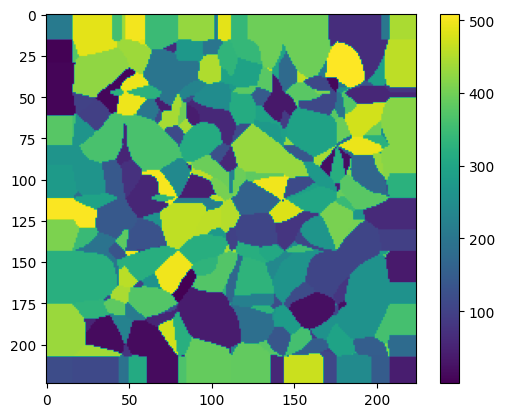

In [11]:
argmax_indices = np.argmax(grads_scale, axis=0)
plt.imshow(argmax_indices, cmap='viridis')  # Displaying the array as an image
plt.colorbar()  # Adding a color bar for reference
plt.show()

In [12]:
l = list(set(argmax_indices.flatten().tolist()))

(-0.5, 223.5, 223.5, -0.5)

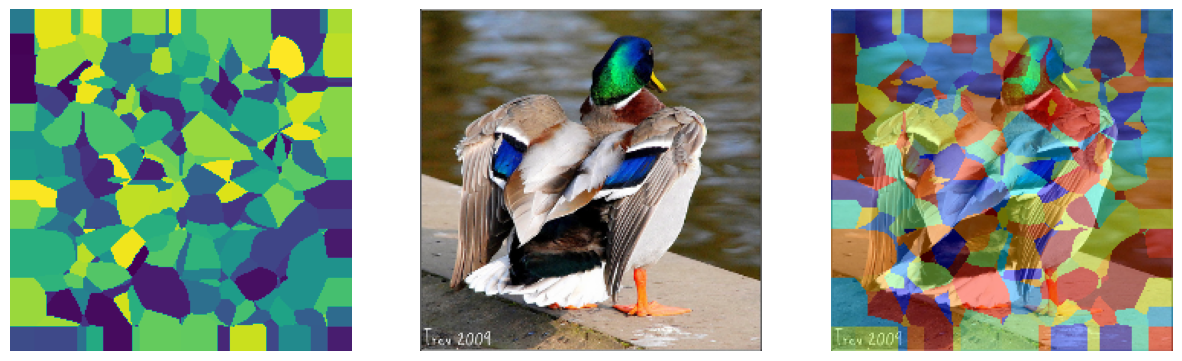

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
visualization = show_cam_on_image(img, np.argmax(grads_scale, axis=0), use_rgb=True)
# visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
axs[0].imshow(np.argmax(grads_scale, axis=0))
axs[0].axis('off')  # Hide axes
axs[1].imshow(img)
# axs[k, 1].set_title(f"grads_visualization", fontsize=10)
axs[1].axis('off')  # Hide axes
axs[2].imshow(visualization)
# axs[k, 1].set_title(f"grads_visualization", fontsize=10)
axs[2].axis('off')  # Hide axes

(-0.5, 223.5, 223.5, -0.5)

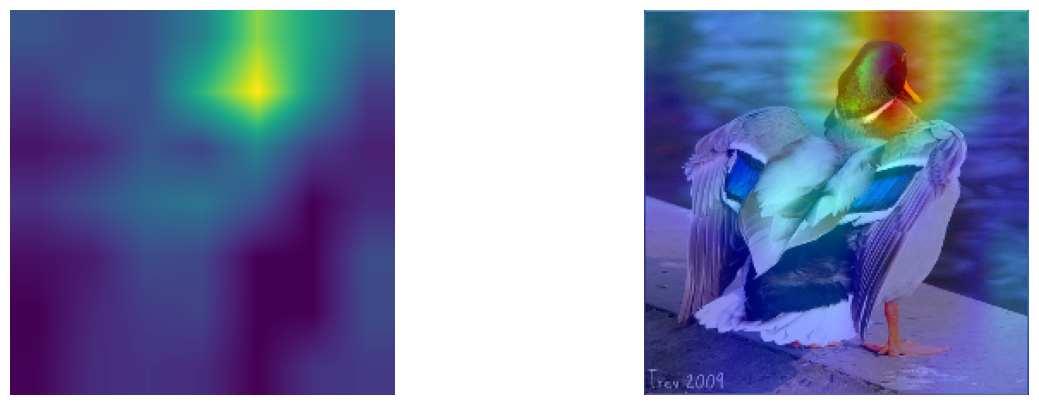

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
axs[0].imshow(grayscale_cam)
axs[0].axis('off')  # Hide axes
axs[1].imshow(visualization)
# axs[k, 1].set_title(f"grads_visualization", fontsize=10)
axs[1].axis('off')  # Hide axes

KeyboardInterrupt: 

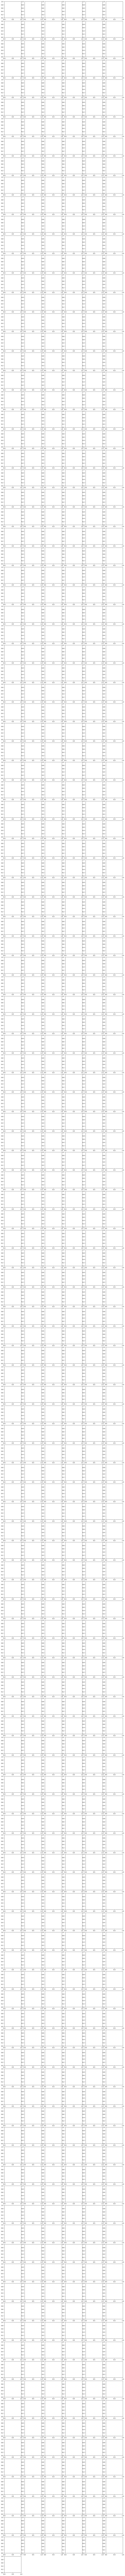

In [15]:
u = len(l)
fig, axs = plt.subplots(u, 6, figsize=(15, 5*(u-1)/2))
for i, k in enumerate(l):
    
    activations_visualization = show_cam_on_image(img, activations_scale[k], use_rgb=True)
    grads_visualization = show_cam_on_image(img, grads_scale[k], use_rgb=True)
    total_visualization = show_cam_on_image(img, activations_scale[k]*grads_scale[k], use_rgb=True)

    axs[i, 0].imshow(activations_visualization)
    axs[i, 0].set_title(f"{k}", fontsize=10)
    axs[i, 0].axis('off')  # Hide axes
    axs[i, 1].imshow(grads_visualization)
    # axs[k, 1].set_title(f"grads_visualization", fontsize=10)
    axs[i, 1].axis('off')  # Hide axes
    axs[i, 2].imshow(activations_scale[k])
    # axs[k, 0].set_title(f"activations_visualization", fontsize=10)
    axs[i, 2].axis('off')  # Hide axes
    axs[i, 3].imshow(grads_scale[k])
    # axs[k, 0].set_title(f"activations_visualization", fontsize=10)
    axs[i, 3].axis('off')  # Hide axes
    axs[i, 4].imshow(activations_scale[k]*grads_scale[k])
    # axs[k, 0].set_title(f"activations_visualization", fontsize=10)
    axs[i, 4].axis('off')  # Hide axes
    axs[i, 5].imshow(total_visualization)
    # axs[k, 0].set_title(f"activations_visualization", fontsize=10)
    axs[i, 5].axis('off')  # Hide axes
plt.show()

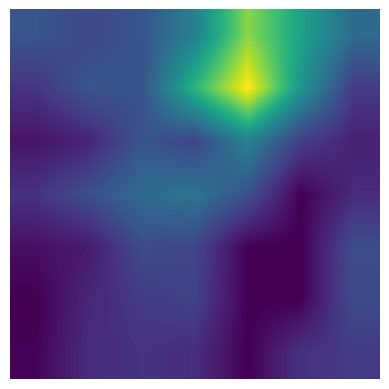

In [ ]:
plt.imshow(grayscale_cam)
plt.axis('off')  # Hide axes
plt.show()

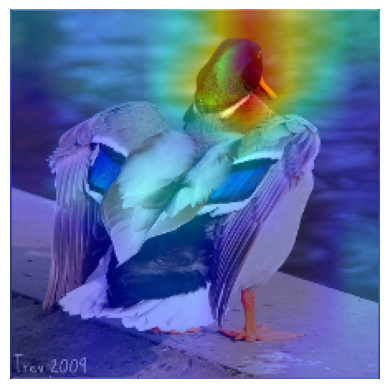

In [ ]:
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# fig, axs = plt.subplots(32, 16, figsize=(10, 5))

# model_CAM = [GradCAM, ScoreCAM, GradCAMPlusPlus, XGradCAM, EigenCAM, LayerCAM, AblationCAM, HiResCAM, FullGrad, RandomCAM]
# # Load and display each image
# for i in range(32):
#     for j in range(16):
#         # Load the image (replace this with your image loading code)
#         # print(model_CAM[5*i+j])
#         index = 16*i+j
#         image = show_cam_on_image(img, scale[index], use_rgb=True)
#         # Display the image
#         axs[i, j].imshow(image)
#         axs[i, j].set_title(f"{index}", fontsize=10)
#         axs[i, j].axis('off')  # Hide axes
# path = f'images_test/test.png'  # Change this to your desired file path
# plt.savefig(path)